In [68]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [69]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

In [70]:
# Run a short test
bus_system = run_simulation(arrival_rate=1.2, service_rate=1, run_until=100)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 13 people in the queue


### First experiment: 100 trials

a. To compute empirical estimates in this simulation, you should run the simulation for at least 100 units of time. This is needed to make sure the simulation is in its equilibrium state. “Equilibrium state” essentially means you reach a state where the initial conditions of the simulation don't matter anymore and the same average behavior is observed for the rest of the time.

b. After 100 units of time, record the queue length at that point in time.

c. Repeat the process above 100 times. This will give you 100 measurements of the queue length in the simulation. These are the results of your experiment.

d. Plot a histogram of the results to visualize the distribution over the queue length.

e. Compute an empirical estimate of the mean queue length for this M/D/1 queue with arrival rate 0.8 and service rate 1, including a 95% confidence interval of the mean.


In [71]:
import matplotlib.pyplot as plt 
import numpy as np 

#plotting a histogram 
#calculating the mean of queue length
def empirical_analysis(arrival_rate, service_rate, run_until, trials):
    lengths = [] # created a list to keep queue lengths after each trial is run

    for i in range(trials):
        #using the simulation above to obtain queue lengths
        bus_system = run_simulation(arrival_rate, service_rate, run_until)
        lengths.append(bus_system.queue.people_in_queue)

    #plotting the histogram 
    plt.figure()
    plt.title(f'Average queue length -{trials} trials')
    plt.xlabel('Observations')
    plt.ylabel('Mean queue length')
     
    #plotting histogram of our lengths
    plt.hist(lengths, bins=15)
    plt.show()
    
    #calculating the average of the queue length 
    mean_queue_length = np.mean(lengths)

    # standard error 
    standard_error = sts.sem(lengths)
    # calculating upper limit of 95% confidence interval
    upper = mean_queue_length + 1.96*standard_error 
    # calculating lower limit of 95% confidence interval
    lower = mean_queue_length - 1.96*standard_error
    
    print( mean_queue_length, " is the average queue length.")
    print("95% confidence interval of population mean is (", round(lower, 4), ",", round(upper,4) ,")","with", round(standard_error,4),"SE.")

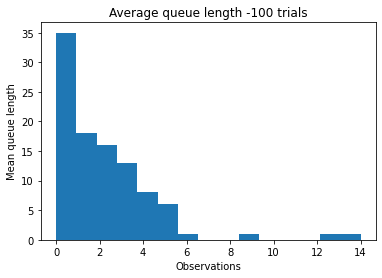

1.93  is the average queue length.
95% confidence interval of population mean is ( 1.4529 , 2.4071 ) with 0.2434 SE.


In [72]:
#adding the values for the 100 trials experiment
arrival_rate = 0.8
service_rate = 1
run_until = 100

trials = 100

empirical_analysis(arrival_rate, service_rate, run_until, trials)

### Second experiment: 1000 trials
    
a. Now, repeat the experiment, but with 1000 trials (repetitions of the simulation) rather than 100 trials. Plot a histogram of the results and compute the average queue length and its confidence interval.


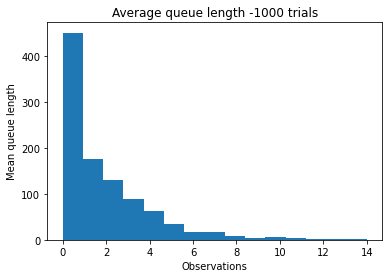

1.578  is the average queue length.
95% confidence interval of population mean is ( 1.4446 , 1.7114 ) with 0.0681 SE.


In [73]:
#adding values for the 1000 trials experiment

arrival_rate = 0.8
service_rate = 1
run_until = 100

trials = 1000

empirical_analysis(arrival_rate, service_rate, run_until, trials)

Compare the results from the two experiments. Comment on the following. 

a. Whether and how the distribution (histogram) over queue length changed.

b. Whether and how the average queue length estimate changed.
    
c. Whether and how the confidence interval of the average queue length changed.

The histogram for both experiments takes a similar form and the mean values are quite similar for both experiments, taking into account the huge difference in sample sizes. Additionally, the standard error in the second experiment is smaller, since we have run the experiment 10 times more than in the first case. 

Next, repeat the experiment but for different values of the arrival rate. Make an error plot of the average queue length and its 95% confidence interval for different values of the arrival rate and determine when the average queue length exceeds 5 people.


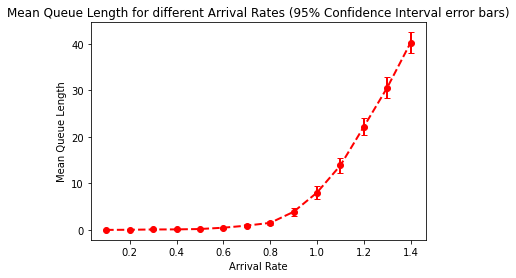

In [82]:
trials = 100

#this function is returning the error and mean queue length 
def empirical_analysis_error(arrival_rate, service_rate, run_until, trials):
    lengths = []

    for i in range(trials):
        bus_system = run_simulation(arrival_rate, service_rate, run_until)
        lengths.append(bus_system.queue.people_in_queue)

    mean_queue_length = np.mean(lengths)
    standard_error = sts.sem(lengths)
    error = 1.96*standard_error
    
    return [mean_queue_length, error]


arrival_rates = []
mean_queue_length = [] 
errors = [] 

for arrival_rate in range(1,15,1): 
    arrival_rate = arrival_rate/10
    trial = empirical_experiment_for_error(arrival_rate, service_rate, run_until, trials)
    arrival_rates.append(arrival_rate)
    mean_queue_length.append(trial[0])
    errors.append(trial[1])

#creating the plot with error bars
plt.figure()

plt.xlabel('Arrival Rate')
plt.ylabel('Mean Queue Length')
plt.title('Mean Queue Length for different Arrival Rates (95% Confidence Interval error bars)')

plt.errorbar(arrival_rates, mean_queue_length, errors, color='red', marker = 'o', capsize=3, linestyle='--', linewidth=2) # Make an error plot
plt.show()

At around 8.5-9 arrival rate we have an average length of 5. After that towards larger arrival rates our length also increases. So does the confidence interval, which is because we also enlargen the number of trials. 